In [1]:
import os
# running from Root directory
os.chdir("..")

In [98]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types, CONNECTOME_SYN_TABLE_PATH, CONNECTOME_NEURON_TABLE_PATH
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from tqdm.notebook import tqdm

In [3]:
Conn = Connectome(from_disk=True)

Connectome:
	#neurons: 71736
	#synapses: 13506902


In [4]:
inh_mat = Conn.get_neuron_conn_matrix(ClfType.inhibitory)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13506902/13506902 [00:53<00:00, 250903.05it/s]


In [5]:
inh_neurons = list(Conn.neurons[Conn.neurons.clf_type == ClfType.inhibitory].root_id)
print(f'total inh neurons: {len(inh_neurons)}')
print(f'total connections: {np.sum(inh_mat)}')
print(f'max synapses between a pair of neurons: {np.amax(inh_mat)}')

max_post_idx, max_pre_idx = np.unravel_index(inh_mat.argmax(), inh_mat.shape)
max_pre_id = inh_neurons[max_pre_idx]
max_post_id = inh_neurons[max_post_idx]

print(f'the max pair indices (pre-post): {max_pre_idx, max_post_idx}')
print(f'the max pair root ids (pre-post): {max_pre_id, max_post_id}')

total inh neurons: 7832
total connections: 941139
max synapses between a pair of neurons: 62
the max pair indices (pre-post): (5682, 6538)
the max pair root ids (pre-post): (864691136108712632, 864691136379657429)


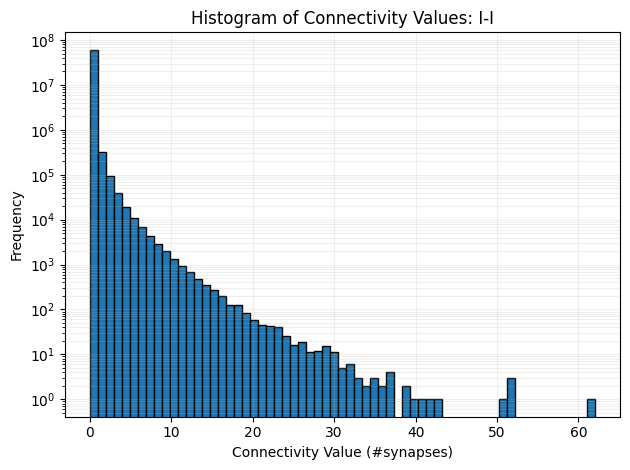

Total elements (N*N): 61340224
Non-zero elements: 512784
Percentage of non-zero elements: 0.84%
Min value: 0
Max value: 62
Mean value: 0.02
Median value: 0.0


In [6]:
flattened_matrix = inh_mat.flatten()

plt.hist(flattened_matrix, bins=63, range=(0, 62), edgecolor='black')
plt.title('Histogram of Connectivity Values: I-I')
plt.xlabel('Connectivity Value (#synapses)')
plt.ylabel('Frequency')
plt.yscale('log') 
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Total elements (N*N): {flattened_matrix.size}")
print(f"Non-zero elements: {np.count_nonzero(flattened_matrix)}")
print(f"Percentage of non-zero elements: {np.count_nonzero(flattened_matrix) / flattened_matrix.size * 100:.2f}%")
print(f"Min value: {flattened_matrix.min()}")
print(f"Max value: {flattened_matrix.max()}")
print(f"Mean value: {flattened_matrix.mean():.2f}")
print(f"Median value: {np.median(flattened_matrix)}")

In [81]:
Z = linkage(inh_mat, 'ward')

num of clusters: 4
[  94 6868  340  530]
threshold: 250
Data point 0: Cluster 2


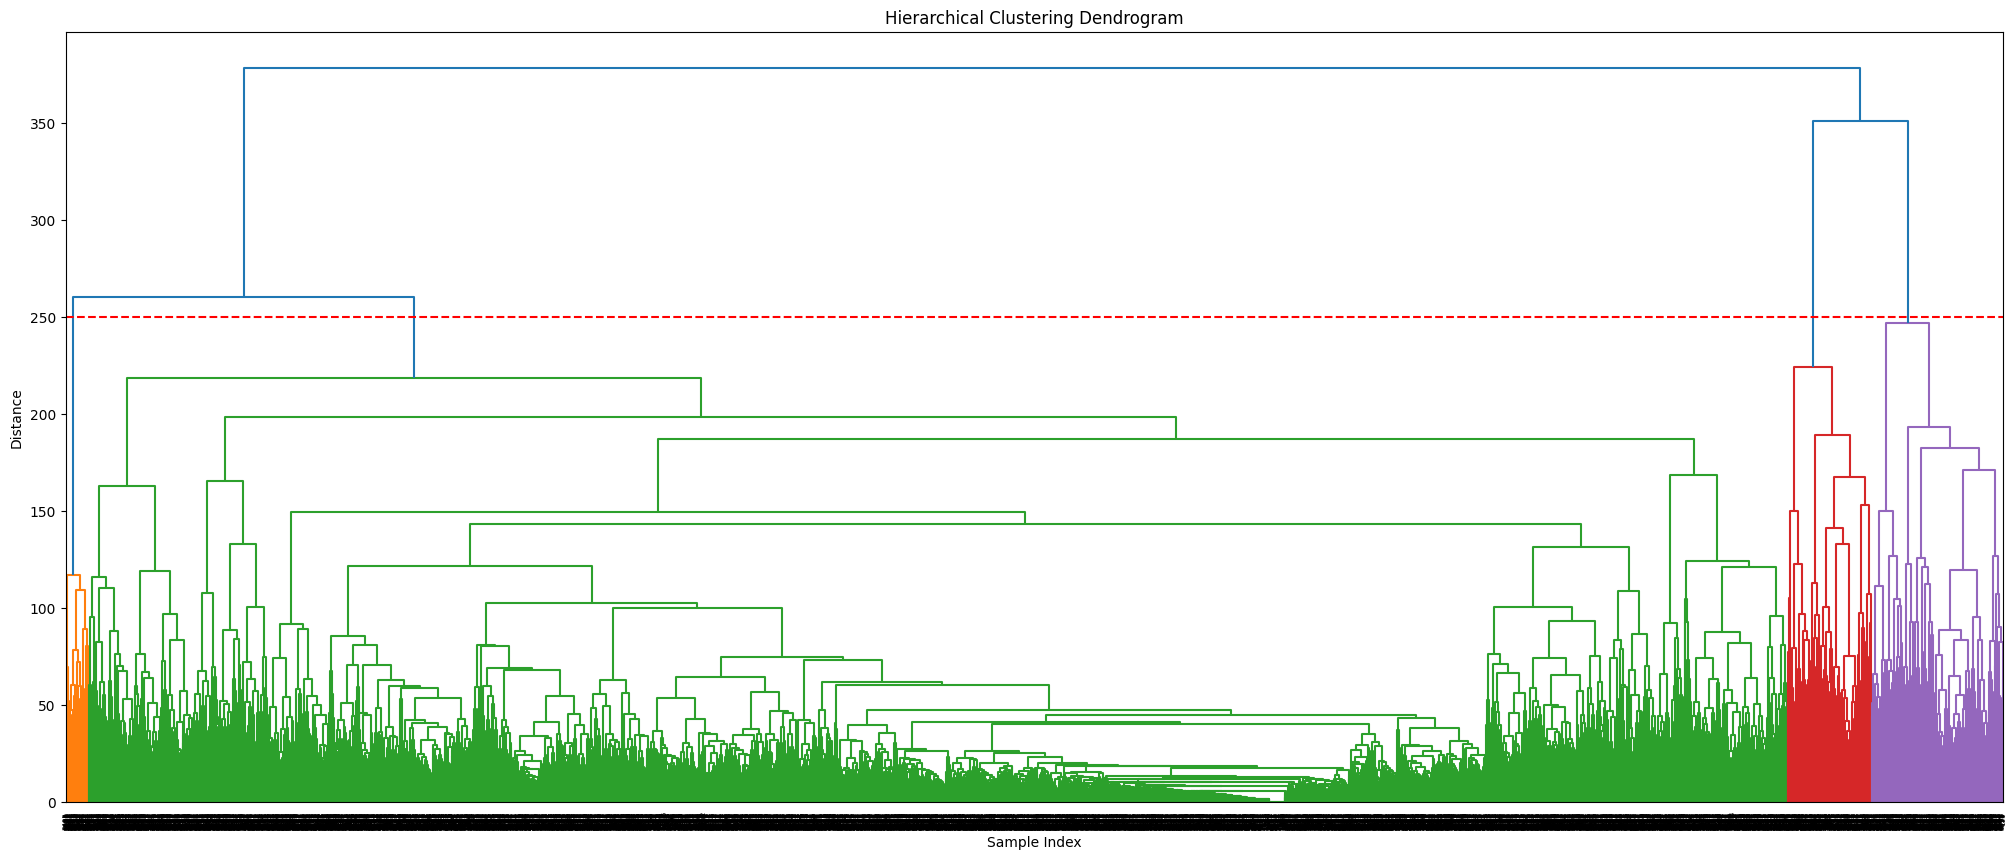

In [84]:
threshold = 0.7*max(Z[:,2]) # default
threshold = 250

clusters = fcluster(Z, threshold, criterion='distance')
values, counts = np.unique(clusters, return_counts=True)
print(f'num of clusters: {len(counts)}')
print(counts)

print(f"threshold: {threshold}")
print(f"Data point {0}: Cluster {clusters[0]}")

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, color_threshold = threshold)

plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [106]:
# allen types
inh_neurons_df = Conn.neurons[Conn.neurons.clf_type == ClfType.inhibitory]
inh_neurons_df.cell_type.value_counts()

cell_type
BC     3328
MC     2450
BPC    1433
NGC     621
Name: count, dtype: int64

In [85]:
# sanity check
# sample = 9
# print(np.sum(inh_mat[sample,:])) # row: incoming connections
# Conn.neuron_lookup[inh_neurons[sample]]['num_of_inh_pre_synapses']

In [107]:
allen_clusters = list(dict(inh_neurons_df.cell_type.value_counts()).keys())
print(allen_clusters)
conf_mat = np.zeros((len(counts), len(counts)), dtype=np.int64)
for i, cluster in tqdm(enumerate(clusters)):
    cell_type = Conn.neuron_lookup[inh_neurons[i]]['cell_type']
    cell_type_idx = allen_clusters.index(cell_type)
    conf_mat[cell_type_idx][cluster-1] += 1

['BC', 'MC', 'BPC', 'NGC']


0it [00:00, ?it/s]

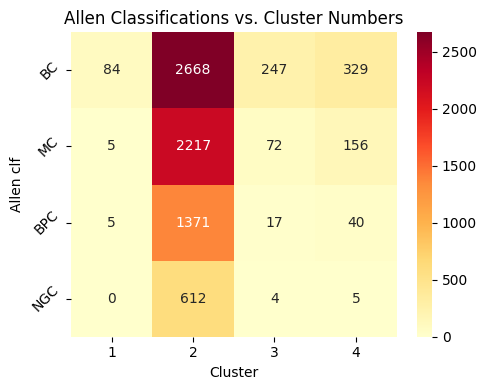

In [140]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=range(1, len(counts) + 1),
            yticklabels=allen_clusters)

plt.xlabel('Cluster');plt.ylabel('Allen clf');plt.yticks(rotation=45)
plt.title('Allen Classifications vs. Cluster Numbers')
plt.tight_layout();plt.show()

In [134]:
cell_type_counts = np.array(inh_neurons_df.cell_type.value_counts())
p_conf_mat = 100 * conf_mat / cell_type_counts[:, np.newaxis]

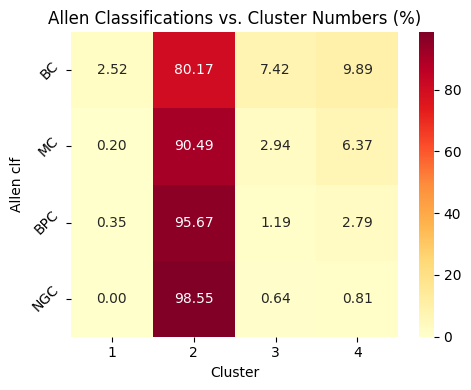

In [143]:
plt.figure(figsize=(5, 4))
sns.heatmap(p_conf_mat, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=range(1, len(counts) + 1),
            yticklabels=allen_clusters)

plt.xlabel('Cluster');plt.ylabel('Allen clf');plt.yticks(rotation=45)
plt.title('Allen Classifications vs. Cluster Numbers (%)')
plt.tight_layout();plt.show()

In [100]:
# # example
# matrix = np.array([[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]])
# Z = linkage((matrix), method='ward')
# threshold = 5
# plt.axhline(y=threshold, color='r', linestyle='--')
# clusters = fcluster(Z, threshold, criterion='distance')
# for i, cluster in enumerate(clusters):
#     print(f"Data point {i}: Cluster {cluster}, data: {matrix[i]}")

# dn = dendrogram(Z, color_threshold=threshold)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Sample Index')
# plt.ylabel('Distance')
# plt.show()

# leaf_labels = dn['leaves']
# for i, leaf in enumerate(leaf_labels):
#     print(f"Leaf {i}: {matrix[i]}, cluster: {clusters[i]} ")